### Multivariate GARCH model:

* Model is given by equations (13.36) and (13.43) from http://sfb649.wiwi.hu-berlin.de/fedc_homepage/xplore/tutorials/sfehtmlnode68.html#bekkmodel

In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, numpy.random as npr, pystan as ps, pickle, pandas
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange

In [2]:
sm = ps.StanModel(file="multivariate_GARCH.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_79078453d2004721aa9cb2af03316bd7 NOW.


#### Load data from file and define dimensions etc:

In [4]:
Y = pandas.read_csv("/xtmp/DC-BATS_data/ozone_data/detrend_data.csv").values
T, dim = np.shape(Y)

### Plot data to visualize them:

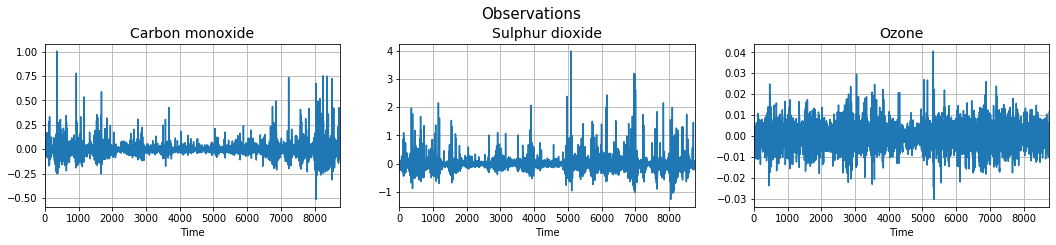

In [5]:
titles = ["Carbon monoxide", "Sulphur dioxide", "Ozone"]
plt.rcParams['figure.figsize'] = (18, 3)
for d in range(dim) :
    plt.subplot(1,dim,d+1)
    plt.plot(Y[:,d])
    plt.grid(True)
    plt.xlabel("Time")
    plt.title(titles[d], fontsize=14)
    plt.xlim(0,T)
plt.suptitle("Observations", y=1.05, fontsize=15);

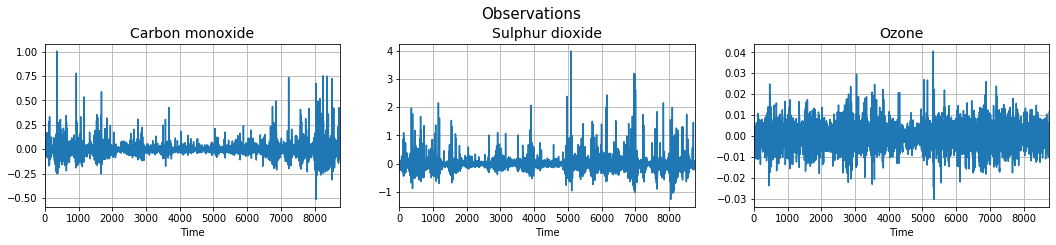

In [21]:
tmax = T
titles = ["Carbon monoxide", "Sulphur dioxide", "Ozone"]
plt.rcParams['figure.figsize'] = (18, 3)
for d in range(dim) :
    plt.subplot(1,dim,d+1)
    plt.plot(Y[0:tmax,d])
    plt.grid(True)
    plt.xlabel("Time")
    plt.title(titles[d], fontsize=14)
    plt.xlim(0,tmax)
plt.suptitle("Observations", y=1.05, fontsize=15);

In [22]:
p = 2
q = 1

In [ ]:
n_chains = 2
n_iter = 200

data = dict(T=tmax, dim=2, p=p, q=q, Y=Y[:tmax,0:2], power=1)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=n_iter)
print(round((time()-start)/60,2), "minutes to run")
trace = fit.extract()

In [ ]:
plt.plot(trace['lp__'])

### Look at posterior samples:

In [44]:
AtA_pow1 = np.zeros((n_mcmc,dim,dim))
AtA_pow5 = np.zeros((n_mcmc,dim,dim))
BtB_pow1 = np.zeros((n_mcmc,dim,dim))
BtB_pow5 = np.zeros((n_mcmc,dim,dim))
CCt_pow1 = np.zeros((n_mcmc,dim,dim))
CCt_pow5 = np.zeros((n_mcmc,dim,dim))

for i in trange(n_mcmc) :
    AtA_pow1[i] = trace_pow1['A'][i,0].transpose().dot(trace_pow1['A'][i,0])
    AtA_pow5[i] = trace_pow5['A'][i,0].transpose().dot(trace_pow5['A'][i,0])
    BtB_pow1[i] = trace_pow1['B'][i,0].transpose().dot(trace_pow1['B'][i,0])
    BtB_pow5[i] = trace_pow5['B'][i,0].transpose().dot(trace_pow5['B'][i,0])
    CCt_pow1[i] = trace_pow1['C0'][i].dot(trace_pow1['C0'][i].transpose())
    CCt_pow5[i] = trace_pow5['C0'][i].dot(trace_pow5['C0'][i].transpose())

100%|██████████| 1000/1000 [00:00<00:00, 38567.60it/s]


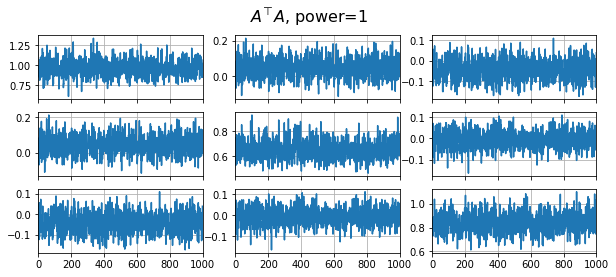

In [47]:
plt.rcParams['figure.figsize'] = (10, 4)
for i in range(dim) :
    for j in range(dim) :
        idx = dim*i+j+1
        plt.subplot(dim,dim,idx)
        plt.plot(AtA_pow1[:,i,j])
        plt.grid(True)
        plt.xlim(0,n_mcmc)
        if i < dim-1 : plt.xticks(alpha=0)
plt.suptitle(r"$A^\top A$, power=1", fontsize=16);

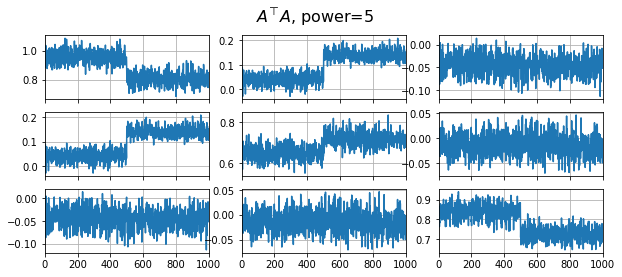

In [48]:
plt.rcParams['figure.figsize'] = (10, 4)
for i in range(dim) :
    for j in range(dim) :
        idx = dim*i+j+1
        plt.subplot(dim,dim,idx)
        plt.plot(AtA_pow5[:,i,j])
        plt.grid(True)
        plt.xlim(0,n_mcmc)
        if i < dim-1 : plt.xticks(alpha=0)
plt.suptitle(r"$A^\top A$, power=5", fontsize=16);

In [55]:
print(np.round(np.var(AtA_pow1[:500],0)/np.var(AtA_pow5[:500],0),1))
print(np.round(np.var(AtA_pow1[500:],0)/np.var(AtA_pow5[500:],0),1))

[[6.6 6.2 5.6]
 [6.2 5.7 5. ]
 [5.6 5.  5.3]]
[[5.2 6.9 6.6]
 [6.9 5.1 3.2]
 [6.6 3.2 6.5]]


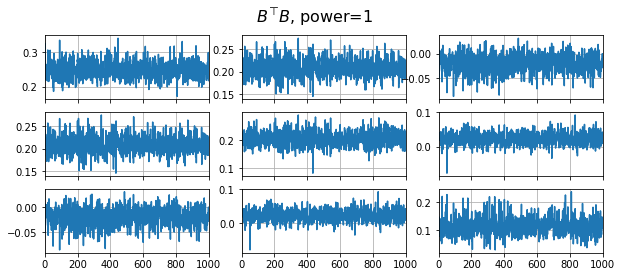

In [49]:
plt.rcParams['figure.figsize'] = (10, 4)
for i in range(dim) :
    for j in range(dim) :
        idx = dim*i+j+1
        plt.subplot(dim,dim,idx)
        plt.plot(BtB_pow1[:,i,j])
        plt.grid(True)
        plt.xlim(0,n_mcmc)
        if i < dim-1 : plt.xticks(alpha=0)
plt.suptitle(r"$B^\top B$, power=1", fontsize=16);

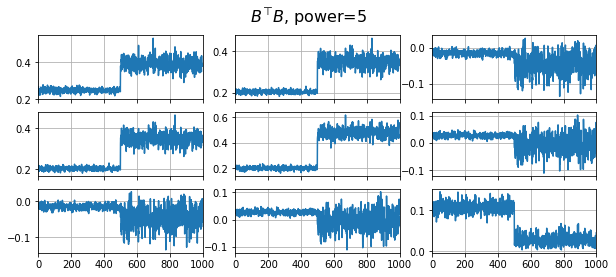

In [50]:
plt.rcParams['figure.figsize'] = (10, 4)
for i in range(dim) :
    for j in range(dim) :
        idx = dim*i+j+1
        plt.subplot(dim,dim,idx)
        plt.plot(BtB_pow5[:,i,j])
        plt.grid(True)
        plt.xlim(0,n_mcmc)
        if i < dim-1 : plt.xticks(alpha=0)
plt.suptitle(r"$B^\top B$, power=5", fontsize=16);

In [56]:
print(np.round(np.var(BtB_pow1[:500],0)/np.var(BtB_pow5[:500],0),1))
print(np.round(np.var(BtB_pow1[500:],0)/np.var(BtB_pow5[500:],0),1))

[[5.2 6.4 7.6]
 [6.4 5.  5.3]
 [7.6 5.3 6.8]]
[[0.5 0.4 0.4]
 [0.4 0.5 0.3]
 [0.4 0.3 6.1]]


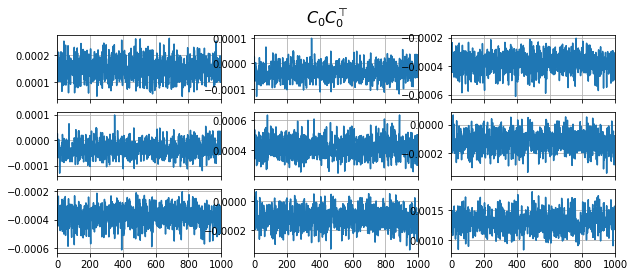

In [32]:
plt.rcParams['figure.figsize'] = (10, 4)
for i in range(dim) :
    for j in range(dim) :
        idx = dim*i+j+1
        plt.subplot(dim,dim,idx)
        plt.plot(CCt_pow1[:,i,j])
        plt.grid(True)
        plt.xlim(0,n_mcmc)
        if i < dim-1 : plt.xticks(alpha=0)
plt.suptitle(r"$C_0 C_0^\top$", fontsize=16);

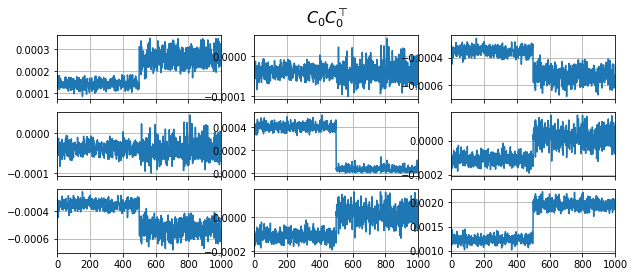

In [31]:
plt.rcParams['figure.figsize'] = (10, 4)
for i in range(dim) :
    for j in range(dim) :
        idx = dim*i+j+1
        plt.subplot(dim,dim,idx)
        plt.plot(CCt_pow5[:,i,j])
        plt.grid(True)
        plt.xlim(0,n_mcmc)
        if i < dim-1 : plt.xticks(alpha=0)
plt.suptitle(r"$C_0 C_0^\top$", fontsize=16);

In [53]:
print(np.round(np.var(CCt_pow1[:500],0)/np.var(CCt_pow5[:500],0),1))

[[4.9 6.  5.9]
 [6.  4.5 6. ]
 [5.9 6.  5.5]]


In [37]:
np.var(CCt_pow1[500::],0)/np.var(CCt_pow5[500::],0)

array([[1.21310319, 1.76932776, 1.62110678],
       [1.76932776, 9.53392145, 1.93996005],
       [1.62110678, 1.93996005, 3.44560512]])